In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import random
import time
from collections import deque
from InfMaxProblem import Monte_Carlo as mc

%matplotlib inline

# データの読み込み

In [85]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data.csv")
network.head()

,# FromNodeId,ToNodeId,WC
0,0,4,0.111111
1,0,5,0.090909
2,0,7,0.333333
3,0,8,0.250000
4,0,9,0.333333


In [86]:
# numpy型に変換
network_np = network.values

In [87]:
# 空の有向グラフを作成
G = nx.DiGraph()

In [88]:
# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [6]:
options = {'node_color': 'cyan',
           'edge_color': 'gray',
           'node_size': 1000,
           'width': 0.5,
          }

In [7]:
pos = nx.spring_layout(G, k=1)

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


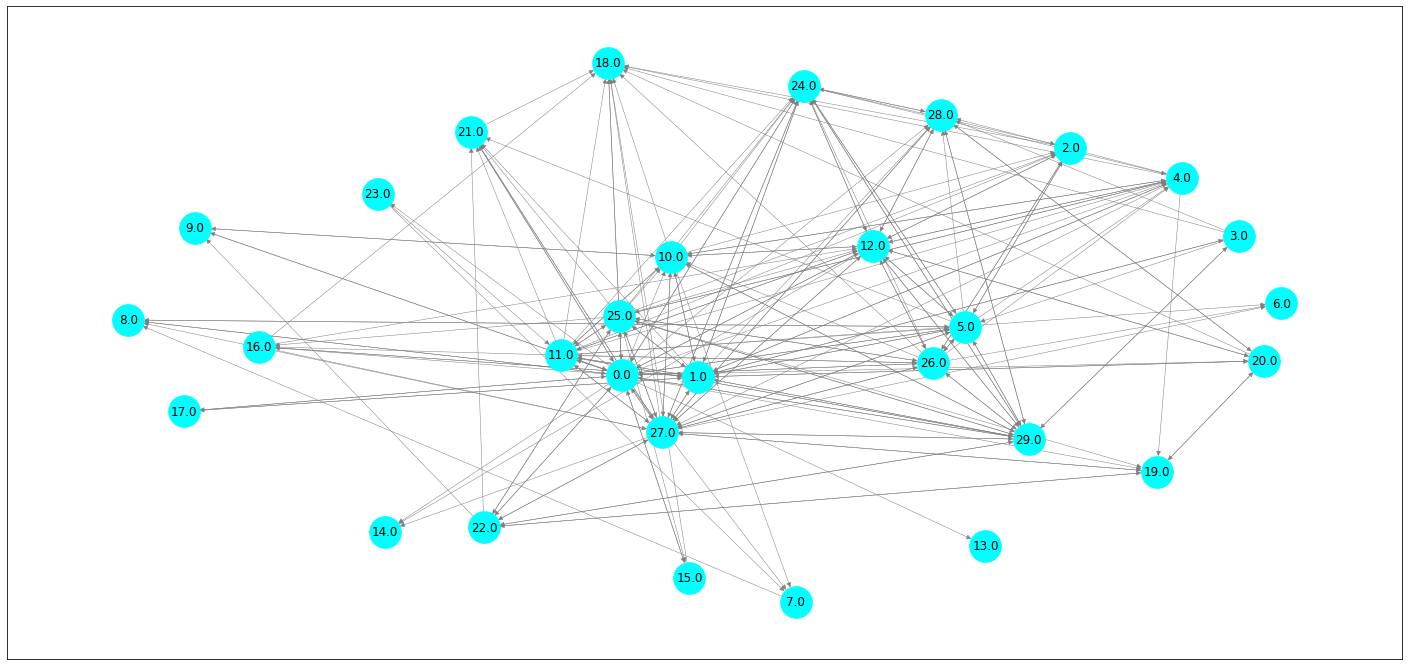

In [8]:
fig = plt.figure(figsize=(25,12))
# nx.draw_networkx_edges(G, pos, **options)
# nx.draw_networkx_nodes(G, pos, **options)
nx.draw_networkx(G, pos, **options)
plt.show()

# greedy

In [14]:
def Greedy_Approx(G, k, T):
    S = []
    V = set(G.node())
    for i in range(k):
        sigma_gain = {s:mc.approx_inf_size_IC_T(G, S+[s], T) - mc.approx_inf_size_IC_T(G, S, T) 
                      for s in V}
        s_maxgain = max(sigma_gain, key=sigma_gain.get)
        
        S.append(s_maxgain)
        V.remove(s_maxgain)
        
    return S

# Greedy_Approx(G, 5, 100)
# [0.0, 25.0, 1.0, 22.0, 27.0]

In [15]:
def CELF(G, k, T):
    S = []
    V = set(G.node())
    lamda = dict([])
    for i in range(k):
        if i == 0:
            lamda[i] = {s:mc.approx_inf_size_IC_T(G, [s], T) for s in V}
            s_ = max(lamda[i], key=lamda[i].get)
        else:
            lamda[i] = dict([])
            max_gain = 0
            for s in V:
                if max_gain <= lamda[i-1][s]:
                    lamda[i][s] = mc.approx_inf_size_IC_T(G, S+[s], T) - mc.approx_inf_size_IC_T(G, S, T)
                    if max_gain <= lamda[i][s]:
                        s_ = s
                        max_gain = lamda[i][s]
                else:
                    lamda[i][s] = lamda[i-1][s]
        S.append(s_)
        V.remove(s_)
    return S

# CELF(G, 5, 100)
# [0.0, 29.0, 27.0, 28.0, 5.0]

In [31]:
def LTLG(G, k, T, R_len):
    S = []
    V = set(G.node())
    lamda = dict([])
    for i in range(k):
        if i == 0:
            lamda[i] = {s:mc.approx_inf_size_IC_T(G, [s], T) for s in V}
            s_ = max(lamda[i], key=lamda[i].get)
        else:
            lamda[i] = dict([])
            max_gain = 0
            R = np.random.choice(list(V), R_len, replace=False)
            for s in V:
                if s in R:
                    if max_gain <= lamda[i-1][s]:
                        lamda[i][s] = mc.approx_inf_size_IC_T(G, S+[s], T) - mc.approx_inf_size_IC_T(G, S, T)
                        if max_gain <= lamda[i][s]:
                            s_ = s
                            max_gain = lamda[i][s]
                    else:
                        lamda[i][s] = lamda[i-1][s]
                else:
                    lamda[i][s] = lamda[i-1][s]
        S.append(s_)
        V.remove(s_)
        
    return S

In [33]:
k = 5
n = G.number_of_nodes()
mini_batch = n // 2

%time S_Greedy = Greedy_Approx(G, 5, 1000)
%time S_CELS = CELF(G, 5, 1000)
%time S_LTLG = LTLG(G, 5, 1000, mini_batch)

CPU times: user 1min 55s, sys: 260 ms, total: 1min 55s
Wall time: 1min 56s
CPU times: user 59.7 s, sys: 232 ms, total: 59.9 s
Wall time: 1min 1s
CPU times: user 44.1 s, sys: 147 ms, total: 44.3 s
Wall time: 45.4 s


In [34]:
mc.approx_inf_size_IC_T(G, S_Greedy, 10000)

20.2199

In [35]:
mc.approx_inf_size_IC_T(G, S_CELS, 10000)

20.3257

In [36]:
mc.approx_inf_size_IC_T(G, S_LTLG, 10000)

20.3637

# 計算実験

In [91]:
def CELF_time(G, k, T=200):
    S = []
    V = set(G.node())
    lamda = dict([])
    time_list = []
    for i in range(k):
        start = time.time()
        if i == 0:
            lamda[i] = {s:mc.approx_inf_size_IC_T(G, [s], T) for s in tqdm(V)}
            s_ = max(lamda[i], key=lamda[i].get)
        else:
            lamda[i] = dict([])
            max_gain = 0
            for s in tqdm(V):
                if max_gain <= lamda[i-1][s]:
                    lamda[i][s] = mc.approx_inf_size_IC_T(G, S+[s], T) - mc.approx_inf_size_IC_T(G, S, T)
                    if max_gain <= lamda[i][s]:
                        s_ = s
                        max_gain = lamda[i][s]
                else:
                    lamda[i][s] = lamda[i-1][s]
        S.append(s_)
        if s_ in V:
            V.remove(s_)
        time_list.append(time.time() - start)
    return S, time_list

## Epinions

In [99]:
run_time = dict([])
S = dict([])

### WC

In [100]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/WC.csv")
network.head()

,# FromNodeId,ToNodeId,WC
0,0,4,0.008000
1,0,5,0.005682
2,0,7,0.033333
3,0,8,0.009615
4,0,9,0.066667


In [101]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [ ]:
start = time.time()
S["WC"], time_list = CELF_time(G, 50)
run_time["WC"] = time.time() - start

In [ ]:
WC_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
WC_df_seed_time

In [ ]:
WC_df_seed_time.plot()

In [ ]:
run_time["WC"]

In [ ]:
S["WC"]

In [98]:
%time Inf_size["WC"] = mc.approx_inf_size_IC_T(G, S["WC"], 10000)

CPU times: user 4.07 s, sys: 10.3 ms, total: 4.08 s
Wall time: 4.11 s
